# Cluster membership probability

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

# Astrometric solution

Open the file which contains the parameter values for each star in GES

In [2]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

# 1.2 Cluster choice

Choosing a good globular cluster according to Clare's recommendation. 


In [14]:
GC=data[data['GES_FLD']=='Trumpler14'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in GC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)
GC

,index,CNAME,CNAME_iDR6_orig,GAIA_eDR3_ID,DIST_GAIA,GES_FLD,OBJECT,FILENAME,GES_TYPE,RA,...,FEH,E_FEH,SYS_ERR_FEH,XI,E_XI,VRAD,E_VRAD,VRAD_OFFSET,GAMMA,E_GAMMA
0,49931,10413404-6001218,10413404-6001218,5254279749443235712,0.1311,Trumpler14,VPHAS_J10413404-6001218,gir_10413404-6001218_H412.4.fit|gir_10413404-6...,GE_CL,160.39183333332682,...,0.03,0.2,0.0,nan,nan,23.11,5.0,-0.24,nan,nan
1,49933,10413434-5958474,10413434-5958474,5254285968555876224,0.0415,Trumpler14,VPHAS_J10413434-5958474,gir_10413434-5958474_H412.4.fit|gir_10413434-5...,GE_CL,160.3930833333268,...,-0.08,0.2,0.0,4.0,0.0,-15.94,5.0,-0.24,nan,nan
2,49939,10413552-6000176,10413552-6000176,5254279856856350336,0.1531,Trumpler14,VPHAS_J10413552-6000176,,GE_CL,160.398,...,nan,nan,nan,nan,nan,17.99,5.0,-0.24,nan,nan
3,49948,10413924-5956023,10413924-5956023,5254286144703865728,0.0686,Trumpler14,VPHAS_J10413924-5956023,,GE_CL,160.4135,...,nan,nan,nan,nan,nan,31.85,5.0,-0.24,nan,nan
4,49962,10414657-5954357,10414657-5954357,5254286453941833984,0.1437,Trumpler14,VPHAS_J10414657-5954357,,GE_CL,160.4440416667,...,nan,nan,nan,nan,nan,-4.02,5.0,-0.24,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,52648,10471038-5954487,10471038-5954487,5350293713307017472,0.121,Trumpler14,VPHAS_J10471038-5954487,,GE_CL,161.79325,...,nan,nan,nan,nan,nan,23.98,0.26,0.04,nan,nan
1898,52651,10471311-5946344,10471311-5946344,5350329821069059072,0.053,Trumpler14,VPHAS_J10471311-5946344,,GE_CL,161.804625,...,nan,nan,nan,nan,nan,-1.7,5.0,-0.24,nan,nan
1899,52655,10471406-5947593,10471406-5947593,5350329722314761472,0.1186,Trumpler14,VPHAS_J10471406-5947593,,GE_CL,161.8085833333,...,nan,nan,nan,nan,nan,2.4,5.0,-0.24,nan,nan
1900,52656,10471499-5953374,10471499-5953374,5350293850745988096,0.1199,Trumpler14,VPHAS_J10471499-5953374,,GE_CL,161.8124583333,...,nan,nan,nan,nan,nan,6.5,1.49,0.04,nan,nan


# 1.3 Gaia Data input

(array([ 34.,  45.,  91., 210., 403., 469., 424., 157.,  41.,  28.]),
 array([160.39183333, 160.53435833, 160.67688333, 160.81940833,
        160.96193333, 161.10445833, 161.24698333, 161.38950833,
        161.53203333, 161.67455833, 161.81708333]),
 <BarContainer object of 10 artists>)

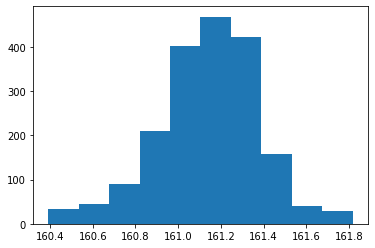

In [20]:
plt.hist(ra)

In [19]:
ra=GC['RA'].astype(float)
dec=GC['DEC'].astype(float)
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius
selection_region=gaia_cone(center[0],center[1],radius/10)

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 161.140707659799, -59.70571305201757)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 161.140707659799, -59.70571305201757, 0.17319492573000944)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Mon, 28 Feb 2022 15:34:33 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'),

# 1.4 Visualising the sample

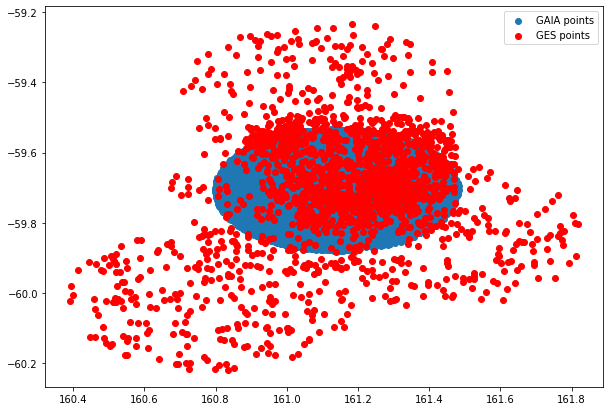

In [23]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

# 1.5 Merging dataframes

We want to have a dataframe and if theres a match in GES then that column gets added.

In [24]:
GC['GAIA_eDR3_ID']=GC['GAIA_eDR3_ID'].astype(int)
selection_region['GAIA_eDR3_ID']=selection_region['source_id']


In [25]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

In [26]:
gaia_not_eso=selection_region[~selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]

Other is the dataframe of ones which don't have GAIA ESO values. We will merge the ones that do with the GAIA ESO values.

In [27]:
globular_cluster_data=pd.DataFrame.merge(GC, gaia_df_gc,on='GAIA_eDR3_ID')

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

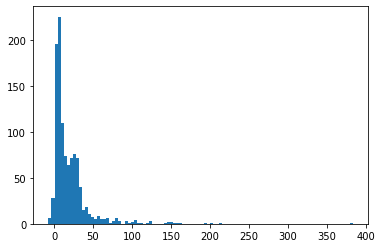

In [28]:
plt.hist(globular_cluster_data['parallax_over_error'],bins=100)
plt.show()

In [29]:
np.std(globular_cluster_data['parallax'])

0.5226751649484415

In [30]:

bound=[globular_cluster_data['parallax'].median()-3*globular_cluster_data['parallax'].std(),globular_cluster_data['parallax'].median()+3*globular_cluster_data['parallax'].std()]

In [31]:
truth1=gaia_not_eso['parallax']>=bound[0]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_8666/1683134010.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


In [32]:
gaia_not_eso['parallax'].min()

-1.164318391567644

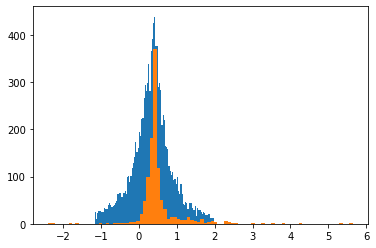

In [33]:
plt.hist(gaia_not_eso['parallax'],bins=100)
plt.hist(globular_cluster_data['parallax'],bins=90)
plt.show()

Even after the parallax cut of 3 sigma there are still plenty of sources.

After making a very conservative cut we are going to attempt to fit the BNN with error.

# 1.7 Making Data into Learning Format.

In [34]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']



(array([  4.,   2.,  18., 927.,  88.,  33.,   5.,   3.,   1.,   2.]),
 array([-2.39155027, -1.58834458, -0.78513889,  0.0180668 ,  0.82127249,
         1.62447817,  2.42768386,  3.23088955,  4.03409524,  4.83730092,
         5.64050661]),
 <BarContainer object of 10 artists>)

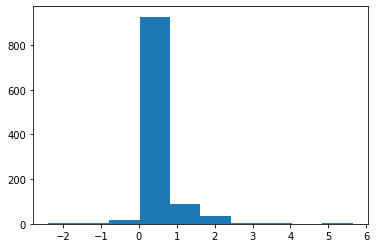

In [35]:
plt.hist((globular_cluster_data['parallax'].astype(float)))

The radial velocity of >300 is so massively diferent can I assume to cut it out?

In [36]:
globular_cluster_data=globular_cluster_data[globular_cluster_data.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]



In [37]:

gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]
data=pd.concat([globular_cluster_data, gaia_not_eso])
input_cluster_data=data[columns_parameters]
input_cluster_data


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_8666/2605390385.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth1]
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_8666/2605390385.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


,ra,dec,parallax,VRAD,pmra,pmdec
0,160.806306,-59.723162,0.491408,62.85,-5.561431,2.552652
1,160.806787,-59.673832,0.636314,-12.61,-12.371792,2.114471
2,160.808567,-59.702925,0.835977,13.84,-6.305775,3.409215
3,160.830284,-59.695429,0.375445,3.19,-5.210904,2.270947
4,160.830697,-59.776143,0.399170,35.57,-5.693985,2.720825
...,...,...,...,...,...,...
12965,161.073338,-59.544993,0.220103,NaN,-2.694150,2.017768
12966,161.043424,-59.540222,0.477728,NaN,-6.575868,2.458498
12967,161.041663,-59.545018,-0.307548,NaN,-6.374311,0.655114
12968,161.037846,-59.545029,0.216632,NaN,-6.328647,2.013520


In [38]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([globular_cluster_data, gaia_not_eso])[columns_error]

# Covariance Error matrix

In [39]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

This follows the paper linked later. The matrix R I use is a diagonal matrix with 1 in the nth position if we have a data reading for the nth feature, and zero otherwise.

For the moment we don't need it to be very complex as we are going to only have two different cases, i.e whether or not a value has radial velocity. 

In [40]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [41]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)

# Definitions of the learning inputs

In [42]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix
learning_R=R
learning_initial_array=globular_cluster_data.to_numpy()

# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In this section I'm following the above paper which adapts the GMM to noisy and missing data. I only apply this to the Gaia eso data at first, and using astrometric data.

Using Bayes Law:
$$ P(C | D)= P(D|C)P(C)\over{P(D)}$$
Let $\textbf{w}_{i}$ be the vector of observed data, and $\textbf{x}_i$ be the vector of 'true' values. Let $R$ be the matrix which projects $\textbf{x}_i$ to $\textbf{w}_i$ and let $S_i$ be a known covariance matrix, so that we assume $$\textbf{w}_i=R_i\textbf{x}_i + \text{noise}$$ where the noise is drawn from a Gaussian distribution with mean 0 and covariance $S_i$

Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [43]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Analysis')

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
learning_input[0:len(globular_cluster_data)]

array([[160.80630598, -59.72316187,   0.49140782,  62.85      ,
         -5.56143149,   2.55265178],
       [160.80678683, -59.67383208,   0.63631432, -12.61      ,
        -12.37179243,   2.11447097],
       [160.80856727, -59.70292471,   0.8359771 ,  13.84      ,
         -6.3057752 ,   3.40921494],
       ...,
       [161.46925067, -59.67389441,   0.44446804, -17.54      ,
         -6.47070115,   3.23237817],
       [161.47087792, -59.71243281,   0.49702604,  57.93      ,
        -14.17858754,   5.00687077],
       [161.47136419, -59.74456708,   0.27621303,   0.        ,
         -6.28344472,   2.55757469]])

# We are only using the Data which is in Gaia Eso and some of the Gaia data now as we have a few bugs to fix.

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

Here we are using 28000 values out of 80000 due to bugs. This also utilises all of the gaia ESO data.

In [66]:
gmm=XDGMM(2).fit(learning_input[0:len(globular_cluster_data)],Xerr=learning_error_covariance[0:len(globular_cluster_data)],R=R[0:len(globular_cluster_data)])

#gmm=XDGMM(2).fit(learning_input,Xerr=learning_error_covariance,R=R)

gmm
endgmm


# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$


The prior is $p(z=i|\theta)=\alpha_i$. This is the posterior probability that an observation has been generated from the $i^{th}$ component

Just Using Gaia ESO Data

In [67]:

comp=gmm.prob_z_given_w(learning_input[0:len(globular_cluster_data)],Xerr=learning_error_covariance[0:len(globular_cluster_data)],R=R[0:len(globular_cluster_data)])


Plotting

In [68]:
df=pd.DataFrame(learning_input[0:len(globular_cluster_data)],columns=columns_parameters)
df2=pd.DataFrame(comp[:,0][0:len(globular_cluster_data)],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,160.806306,-59.723162,0.491408,62.85,-5.561431,2.552652,5.196412e-02
1,160.806787,-59.673832,0.636314,-12.61,-12.371792,2.114471,1.017504e-10
2,160.808567,-59.702925,0.835977,13.84,-6.305775,3.409215,1.554983e-08
3,160.830284,-59.695429,0.375445,3.19,-5.210904,2.270947,9.963319e-01
4,160.830697,-59.776143,0.399170,35.57,-5.693985,2.720825,9.620117e-01
...,...,...,...,...,...,...,...
1078,161.461565,-59.699593,0.888103,47.93,10.434687,-3.947003,1.197970e-145
1079,161.468865,-59.657708,0.462271,10.12,-7.787673,4.145396,9.345674e-01
1080,161.469251,-59.673894,0.444468,-17.54,-6.470701,3.232378,9.990524e-01
1081,161.470878,-59.712433,0.497026,57.93,-14.178588,5.006871,7.554915e-20


In [69]:
sum(plot_df[0:len(globular_cluster_data)]['prob']>=0.99)

661

So just using the original sample there is 661 with prob greater than 0.99

# 2 Plot the parameters vs membership.

GAIA ESO

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

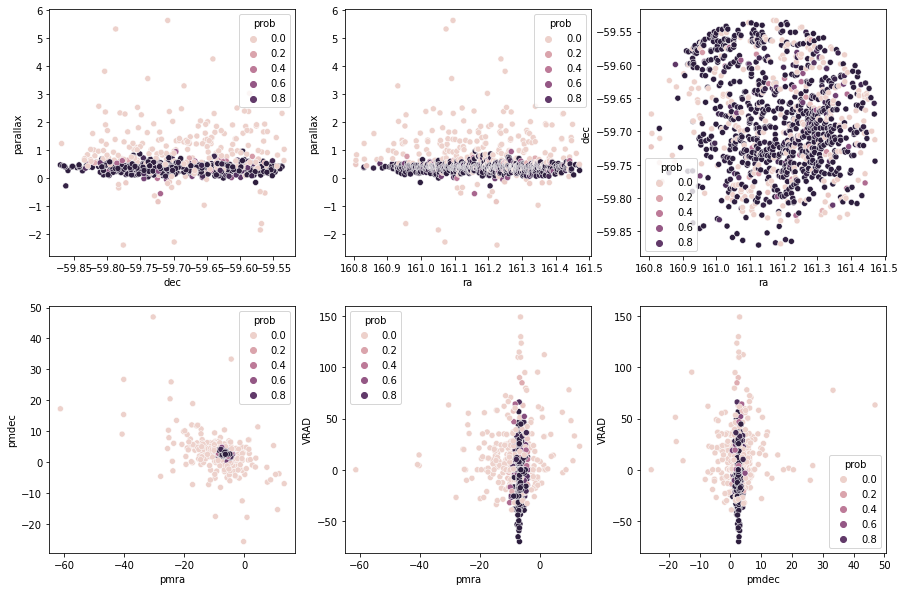

In [70]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Adding Gaia data to the gaia eso

In [71]:
gmm=XDGMM(2).fit(learning_input,Xerr=learning_error_covariance,R=R)
comp=gmm.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,1],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

gmm
endgmm


,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,160.806306,-59.723162,0.491408,62.85,-5.561431,2.552652,1.000000
1,160.806787,-59.673832,0.636314,-12.61,-12.371792,2.114471,1.000000
2,160.808567,-59.702925,0.835977,13.84,-6.305775,3.409215,0.999590
3,160.830284,-59.695429,0.375445,3.19,-5.210904,2.270947,0.002216
4,160.830697,-59.776143,0.399170,35.57,-5.693985,2.720825,1.000000
...,...,...,...,...,...,...,...
12270,161.073338,-59.544993,0.220103,0.00,-2.694150,2.017768,0.547133
12271,161.043424,-59.540222,0.477728,0.00,-6.575868,2.458498,0.006578
12272,161.041663,-59.545018,-0.307548,0.00,-6.374311,0.655114,0.082442
12273,161.037846,-59.545029,0.216632,0.00,-6.328647,2.013520,0.005455


In [72]:
plot_df['prob']=1-plot_df['prob']

In [79]:
sum(plot_df[0:len(globular_cluster_data)]['prob']>=0.2)

453

GAIA ESO AND GAIA

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

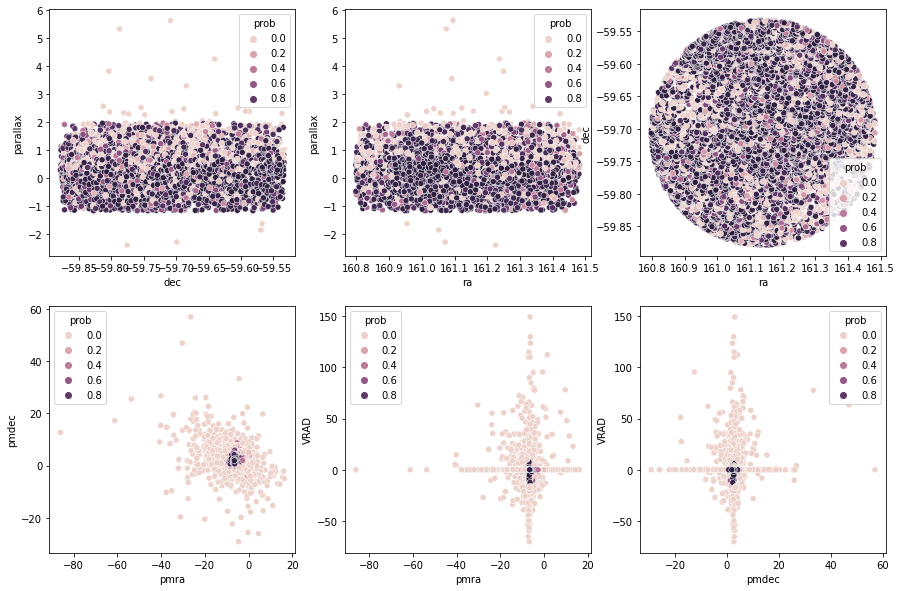

In [80]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Colour Magnitude Diagrams

In [243]:
globular_cluster_data=globular_cluster_data.reset_index()


,index,index_x,CNAME,CNAME_iDR6_orig,GAIA_eDR3_ID,DIST_GAIA,GES_FLD,OBJECT,FILENAME,GES_TYPE,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,membership
0,0,1794,00212293-7205029,00212293-7205029,4689618925875604224,0.1034,NGC104,50005964,gir_00212293-7205029_H548.8.fit|gir_00212293-7...,GE_SD_GC,...,0,NaN,NaN,NaN,306.184891,-44.853762,311.011425,-62.176861,0.209283,True
1,1,1799,00213442-7208534,00213442-7208534,4689614837066802944,0.0999,NGC104,6808,,AR_SD_GC,...,0,NaN,NaN,NaN,306.149629,-44.793008,310.911541,-62.223191,0.206532,True
2,2,1800,00213645-7207194,00213645-7207194,4689617860723748864,0.1905,NGC104,50004171,gir_00213645-7207194_H548.8.fit|gir_00213645-7...,GE_SD_GC,...,0,NaN,NaN,NaN,306.151884,-44.819216,310.962192,-62.211701,0.196625,True
3,3,1801,00213961-7202517,00213961-7202517,4689619338192422784,0.1358,NGC104,47TUC-00031830,gar_00213961-7202517_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,306.163458,-44.893205,311.101949,-62.175765,0.190300,True
4,4,1802,00214371-7205162,00214371-7205162,4689618238680828800,0.0809,NGC104,104RGB002,gar_00214371-7205162_H665.0.fit,AR_SD_GC,...,8,5000.0,3.0,0.0,306.146948,-44.854461,311.034892,-62.201440,0.182793,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,559,2370,00262402-7206050,00262402-7206050,4689629714836034048,0.1416,NGC104,47TUC-00110197,gar_00262402-7206050_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,305.643046,-44.894798,311.414392,-62.514717,0.178378,NaN
535,560,2371,00262629-7200544,00262629-7200544,4689633941083703424,0.1525,NGC104,10006039,gir_00262629-7200544_H548.8.fit|gir_00262629-7...,GE_SD_GC,...,0,NaN,NaN,NaN,305.655722,-44.980645,311.577417,-62.472512,0.190566,NaN
536,561,2372,00262887-7204421,00262887-7204421,4689629779253913984,0.098,NGC104,80006963,gir_00262887-7204421_H548.8.fit|gir_00262887-7...,GE_SD_GC,...,0,NaN,NaN,NaN,305.638812,-44.918485,311.464103,-62.508117,0.183101,NaN
537,562,2373,00263090-7208534,00263090-7208534,4689628615324452608,0.5541,NGC104,104EAGB12,gar_00263090-7208534_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,305.621678,-44.849705,311.337484,-62.546407,0.198387,NaN


In [248]:
globular_cluster_data[plot_df['prob']>=0.9]

,index,index_x,CNAME,CNAME_iDR6_orig,GAIA_eDR3_ID,DIST_GAIA,GES_FLD,OBJECT,FILENAME,GES_TYPE,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,membership
0,0,1794,00212293-7205029,00212293-7205029,4689618925875604224,0.1034,NGC104,50005964,gir_00212293-7205029_H548.8.fit|gir_00212293-7...,GE_SD_GC,...,0,NaN,NaN,NaN,306.184891,-44.853762,311.011425,-62.176861,0.209283,True
1,1,1799,00213442-7208534,00213442-7208534,4689614837066802944,0.0999,NGC104,6808,,AR_SD_GC,...,0,NaN,NaN,NaN,306.149629,-44.793008,310.911541,-62.223191,0.206532,True
2,2,1800,00213645-7207194,00213645-7207194,4689617860723748864,0.1905,NGC104,50004171,gir_00213645-7207194_H548.8.fit|gir_00213645-7...,GE_SD_GC,...,0,NaN,NaN,NaN,306.151884,-44.819216,310.962192,-62.211701,0.196625,True
3,3,1801,00213961-7202517,00213961-7202517,4689619338192422784,0.1358,NGC104,47TUC-00031830,gar_00213961-7202517_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,306.163458,-44.893205,311.101949,-62.175765,0.190300,True
4,4,1802,00214371-7205162,00214371-7205162,4689618238680828800,0.0809,NGC104,104RGB002,gar_00214371-7205162_H665.0.fit,AR_SD_GC,...,8,5000.0,3.0,0.0,306.146948,-44.854461,311.034892,-62.201440,0.182793,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,558,2369,00262278-7203182,00262278-7203182,4689633013370839936,0.1132,NGC104,47TUC-00112473,gar_00262278-7203182_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,305.654248,-44.940482,311.498499,-62.489381,0.176835,NaN
534,559,2370,00262402-7206050,00262402-7206050,4689629714836034048,0.1416,NGC104,47TUC-00110197,gar_00262402-7206050_H665.0.fit,AR_SD_GC,...,0,NaN,NaN,NaN,305.643046,-44.894798,311.414392,-62.514717,0.178378,NaN
535,560,2371,00262629-7200544,00262629-7200544,4689633941083703424,0.1525,NGC104,10006039,gir_00262629-7200544_H548.8.fit|gir_00262629-7...,GE_SD_GC,...,0,NaN,NaN,NaN,305.655722,-44.980645,311.577417,-62.472512,0.190566,NaN
536,561,2372,00262887-7204421,00262887-7204421,4689629779253913984,0.098,NGC104,80006963,gir_00262887-7204421_H548.8.fit|gir_00262887-7...,GE_SD_GC,...,0,NaN,NaN,NaN,305.638812,-44.918485,311.464103,-62.508117,0.183101,NaN


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_7334/3022383761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-2.5*np.log10((1/selection_gaia['parallax']/10.0)**2)
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_7334/3022383761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-2.5*np.log10((1/selection_gaia['parallax']/10.0)**2

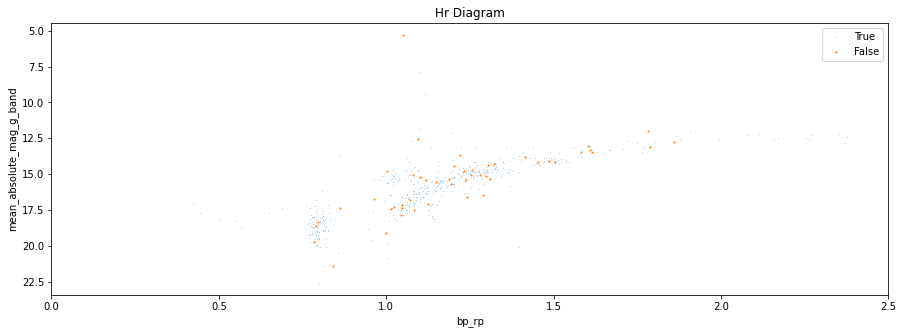

In [216]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-2.5*np.log10((1/selection_gaia['parallax']/10.0)**2)
    return selection_gaia




f, axes = plt.subplots(1, 1)

f.set_figheight(5)
f.set_figwidth(15)
scatter=mean_basolute_mag_g_band(globular_cluster_data[globular_cluster_data['membership']==True])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=0.5,label='True')

scatter=mean_basolute_mag_g_band(globular_cluster_data[globular_cluster_data['membership']==False])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='False')

axes.set_xlim(0,2.5)

axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram")
plt.show()

# Use BIC to select number of components

TODO

# Posterior.
https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

In [217]:
parallax=learning_input[0:len(globular_cluster_data)].transpose()[2]
pm_ra=learning_input[0:len(globular_cluster_data)].transpose()[4]
pm_dec=learning_input[0:len(globular_cluster_data)].transpose()[5]
vrad=learning_input[0:len(globular_cluster_data)].transpose()[3]

# Next need to use the found parameters to custom define a Gaussian mixture model and then do so to estimate probablilities.